In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import os

/tmp/ipykernel_3087280/3225291598.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  spring_cmap = get_cmap('spring')


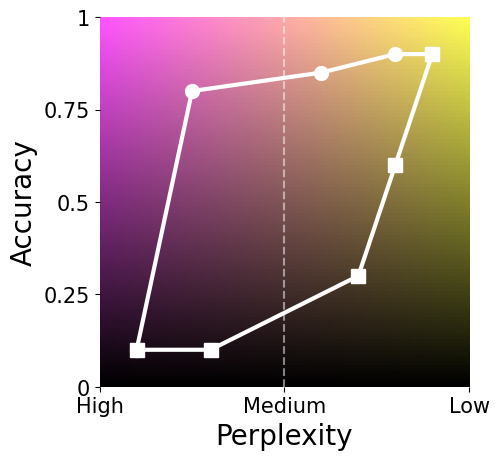

In [4]:

spring_cmap = get_cmap('spring')


def cmap(X, Y):
    """
    A custom colormap function that takes two inputs:
    - X: values representing the dark to light gradient (0 to 1)
    - Y: values representing positions along the spring colormap (0 to 1)
    
    Returns the color values for each (X, Y) coordinate.
    """
    # Normalize the X values (for dark to light gradient)
    norm = Normalize(vmin=0, vmax=1)
    dark_to_light = norm(X)
    
    # Get the colors from the spring colormap for Y values
    spring_colors = (spring_cmap(1-Y)  + 0.5*np.ones_like(spring_cmap(1-Y) )) / 1.5
    
    # Modulate the spring colors by the dark to light gradient
    combined_colors = dark_to_light[:, :, np.newaxis] * spring_colors[:, :, :3]
    
    return combined_colors

# Create test grid
n = 100
x = np.linspace(0, 1, n)  # Dark to light gradient
y = np.linspace(0, 1, n)  # Spring colormap values
X, Y = np.meshgrid(x, y)

# Apply the cmap function to the grid
colors = cmap(X, Y)

# Plot the result
plt.imshow(np.flip(np.swapaxes(colors,0, 1), axis=1), origin='lower', extent=[0, 1, 0, 1])
plt.xlabel('Perplexity', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks([0, 0.5, 1], ['High', 'Medium', 'Low'], fontsize = 15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1], fontsize = 15)
plt.vlines(0.5, 0, 1, color='white', linestyle='--', alpha=0.5, label='Memorization threshold')

plt.plot([0.1, 0.25, 0.6, 0.8, 0.9], [0.1, 0.8, 0.85, 0.9, 0.9], 'o-', color='white', label='Example 1 Learning Progression', markersize=10, linewidth=3)
plt.plot([0.1, 0.3, 0.7, 0.8, 0.9], [0.1, 0.1, 0.3, 0.6, 0.9], 's-', color='white', markersize=10, linewidth=3, label='Example 2 Learning Progression')

# plt.scatter([0.25, 0.3], [0.8, 0.1], marker="D",facecolors='none', s=500, edgecolor='white', linewidth=2, label = "Pre-Memorization Train Accuracy")
# plt.scatter([ 0.9], [0.9], marker="o",facecolors='none', s=700, edgecolor='white', linewidth=2, label = "Pre-Memorization Train Accuracy")

plt.gca().spines['top'].set_linewidth(0)
plt.gca().spines['right'].set_linewidth(0)
plt.gca().spines['bottom'].set_linewidth(0)
plt.gca().spines['left'].set_linewidth(0)


plt.show()


In [8]:
answer_type_names = ["types5_seed2_temp0.8", "types50_seed2_temp0.8", "types5_seed2", "types50_seed2", "types10_seed2_temp0.8"]


def get_stats(train_name):
    train_accs_all = []
    perplexities_all = []


    ckpts = sorted([
    f for f in os.listdir("ckpts/"+train_name) if os.path.isdir(os.path.join("ckpts/"+train_name, f))
    ], key=lambda x: int(x.split('-')[1]))

    for ckpt in ckpts:
        
        for answer_type_name in answer_type_names:
            try:
                train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_"+answer_type_name+".npy")==0)
                break
            except:
                pass
        train_accs = train_correct.mean(axis=-1)
        train_accs_all.append(train_accs)
        
        perplexities = np.load("ckpts/"+train_name+"/"+ckpt+ "/train_perplexities.npy")
        perplexities_all.append(perplexities)
        
    if "full" not in train_name:
        subsample_idxs = np.load("ckpts/"+train_name+"/subsample_idxs.npy")
    else:
        subsample_idxs = np.arange(len(train_accs_all[0]))
    
    train_accs_all = np.array(train_accs_all)[:, subsample_idxs]
    perplexities_all = np.array(perplexities_all)[:, subsample_idxs]
    
    
    
    test_accs_all = []

    for ckpt in ckpts:
        for answer_type_name in answer_type_names:
            try:
                test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_"+answer_type_name+".npy")==0)
                break
            except:
                pass
        test_accs_all.append(test_accs)

    test_accs_all = np.array(test_accs_all)
    
    return_dict = {}
    return_dict["train_accs_all"] = train_accs_all
    return_dict["perplexities_all"] = perplexities_all
    return_dict["test_accs_all"] = test_accs_all
    
    return return_dict


def get_ratios(stats_dict, perp_threshold=-2.5):
    train_accs_all = stats_dict["train_accs_all"]
    perplexities_all = stats_dict["perplexities_all"]
    test_accs_all = stats_dict["test_accs_all"]
    
    memorization_mask = np.ones(train_accs_all.shape)*-1
    accs_all = np.ones(train_accs_all.shape)*-1
    
    for i in range(len(train_accs_all)):
        accs_all[i] =train_accs_all[i]
        memorization_mask[i] = (np.log(np.log((perplexities_all[i]))) >= perp_threshold)
    
    
    unmemorized_acc_cummax = np.array([(accs_all*memorization_mask)[:j+1].max(axis=0) for j in range(len(train_accs_all))])
    unmemorized_acc_cummax = (np.min([unmemorized_acc_cummax, accs_all], axis=0))
    unmemorized_acc_cummax_mean = unmemorized_acc_cummax.mean(axis=1)
    avg_test_acc = test_accs_all.mean(axis=1).mean(axis=1)
    
    
    return_dict = {} 
    return_dict["unmemorized_acc_cummax"] = unmemorized_acc_cummax_mean
    return_dict["unmemorized_acc_cummax_all"] = unmemorized_acc_cummax
    return_dict["avg_test_acc"] = avg_test_acc
            
    return return_dict


Text(0.5, 1.0, 'LR 2e-4')

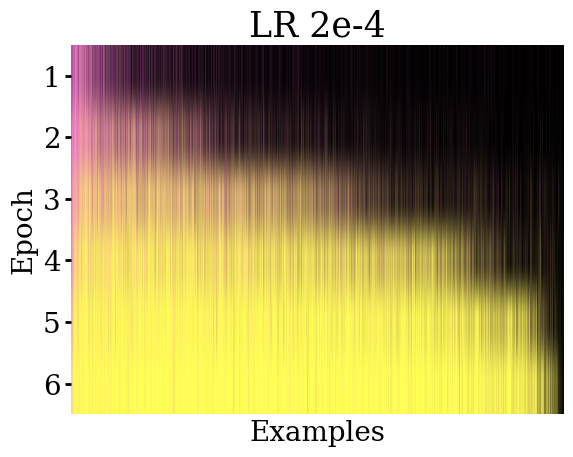

In [13]:
file_name = "gsm8k_orig_6epochs_full_lr0.0002_bs128"


stats_dict = get_stats(file_name)
ratio_dict = get_ratios(stats_dict, perp_threshold=-2.4)


colors = cmap(stats_dict["train_accs_all"], (np.clip(np.log(np.log(stats_dict["perplexities_all"])), -2.4-2.4, 0)+(2.4*2))/(2*2.4))

ordered_idxs =np.argsort((stats_dict["train_accs_all"].mean(axis=0)+0.5*((np.clip(np.log(np.log(stats_dict["perplexities_all"])), -2.4-2.4, 0)+(2.4*2))/(2*2.4)).mean(axis=0)))
ordered_idxs = np.flip(ordered_idxs)


plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'DejaVu Serif',
})


plt.imshow(np.flip(colors[:, ordered_idxs, :], axis=0), origin='lower', extent=[0, 8, 0, 6])
plt.xticks([])
plt.yticks([5.5, 4.5, 3.5, 2.5, 1.5, 0.5], ["1", "2", "3", "4", "5", "6"], fontsize=20)

plt.gca().spines['top'].set_linewidth(0)
plt.gca().spines['right'].set_linewidth(0)
plt.gca().spines['bottom'].set_linewidth(0)
plt.gca().spines['left'].set_linewidth(0)
plt.tick_params(width=2, length=4)


plt.xlabel("Examples", fontsize=20)
plt.ylabel("Epoch", fontsize=20)
plt.title("LR 2e-4", fontsize=25)


Text(0.5, 1.0, 'LR 2e-5')

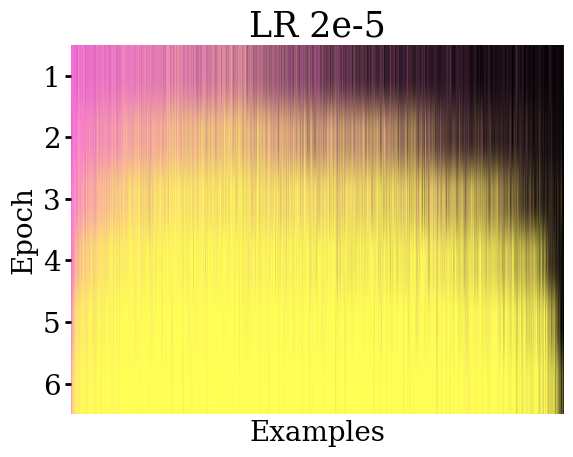

In [14]:
file_name = "gsm8k_orig_6epochs_full_lr2e-05_bs128"


stats_dict = get_stats(file_name)
ratio_dict = get_ratios(stats_dict, perp_threshold=-2.4)


colors = cmap(stats_dict["train_accs_all"], (np.clip(np.log(np.log(stats_dict["perplexities_all"])), -2.4-2.4, 0)+(2.4*2))/(2*2.4))

ordered_idxs =np.argsort((stats_dict["train_accs_all"].mean(axis=0)+0.5*((np.clip(np.log(np.log(stats_dict["perplexities_all"])), -2.4-2.4, 0)+(2.4*2))/(2*2.4)).mean(axis=0)))
ordered_idxs = np.flip(ordered_idxs)


plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'DejaVu Serif',
})


plt.imshow(np.flip(colors[:, ordered_idxs, :], axis=0), origin='lower', extent=[0, 8, 0, 6])
plt.xticks([])
plt.yticks([5.5, 4.5, 3.5, 2.5, 1.5, 0.5], ["1", "2", "3", "4", "5", "6"], fontsize=20)

plt.gca().spines['top'].set_linewidth(0)
plt.gca().spines['right'].set_linewidth(0)
plt.gca().spines['bottom'].set_linewidth(0)
plt.gca().spines['left'].set_linewidth(0)
plt.tick_params(width=2, length=4)


plt.xlabel("Examples", fontsize=20)
plt.ylabel("Epoch", fontsize=20)
plt.title("LR 2e-5", fontsize=25)


Text(0.5, 1.0, 'LR 2e-5')

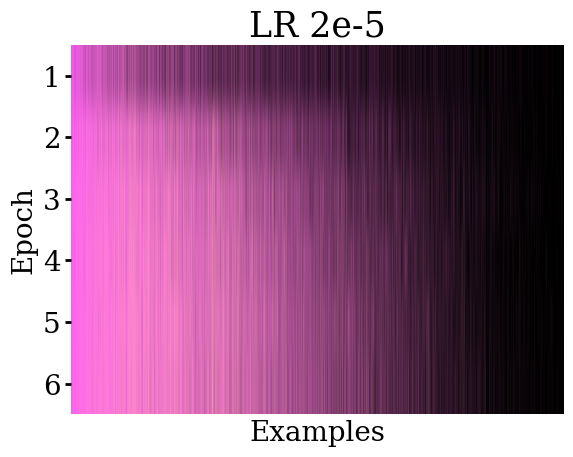

In [15]:
file_name = "gsm8k_orig_6epochs_full_lr5e-07_bs128"



stats_dict = get_stats(file_name)
ratio_dict = get_ratios(stats_dict, perp_threshold=-2.4)


colors = cmap(stats_dict["train_accs_all"], (np.clip(np.log(np.log(stats_dict["perplexities_all"])), -2.4-2.4, 0)+(2.4*2))/(2*2.4))

ordered_idxs =np.argsort((stats_dict["train_accs_all"].mean(axis=0)+0.5*((np.clip(np.log(np.log(stats_dict["perplexities_all"])), -2.4-2.4, 0)+(2.4*2))/(2*2.4)).mean(axis=0)))
ordered_idxs = np.flip(ordered_idxs)


plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'DejaVu Serif',
})


plt.imshow(np.flip(colors[:, ordered_idxs, :], axis=0), origin='lower', extent=[0, 8, 0, 6])
plt.xticks([])
plt.yticks([5.5, 4.5, 3.5, 2.5, 1.5, 0.5], ["1", "2", "3", "4", "5", "6"], fontsize=20)

plt.gca().spines['top'].set_linewidth(0)
plt.gca().spines['right'].set_linewidth(0)
plt.gca().spines['bottom'].set_linewidth(0)
plt.gca().spines['left'].set_linewidth(0)
plt.tick_params(width=2, length=4)


plt.xlabel("Examples", fontsize=20)
plt.ylabel("Epoch", fontsize=20)
plt.title("LR 2e-5", fontsize=25)
